# Set-Up

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Set matplotlib parameters for publication quality
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "serif"  # Use generic serif instead of Times
plt.rcParams["font.weight"] = "normal"

# Establish colorblind-friendly palette
colors = sns.color_palette('colorblind')


# Preprocess (Across Layers)

In [21]:
import os
import re
import pandas as pd
from pathlib import Path

BASE_PATH = 'data/sae_latent_eval/nt50_base_saes'
BASE_PATH_MLP = 'data/sae_latent_eval/MLP-neuron-baseline'

def load_and_merge_csvs(folder_path):
    """Load all CSV files from a folder and merge them on 'latent_id' and 'annotation'."""
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    if not csv_files:
        return pd.DataFrame()

    merged_df = pd.read_csv(os.path.join(folder_path, csv_files[0]))
    for file in csv_files[1:]:
        temp_df = pd.read_csv(os.path.join(folder_path, file))
        merged_df = pd.merge(
            merged_df,
            temp_df,
            on=['latent_id', 'annotation'],
            how='outer',
            suffixes=('', '_temp')
        )

    return merged_df


def extract_layer_signature(folder_name):
    """Extract the 'L#' part from folder name (e.g., 'L0', 'L11')."""
    match = re.search(r'(L\d+)', folder_name)
    return match.group(1) if match else None


def load_all_layers(base_path):
    """
    Iterate over all subfolders, load & merge CSVs in each,
    and return a dictionary keyed by layer signature (e.g. 'L0', 'L3').
    """
    layer_data = {}

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        layer_sig = extract_layer_signature(folder)
        if layer_sig:
            print(f"Processing {folder} (→ {layer_sig})")
            df = load_and_merge_csvs(folder_path)
            layer_data[layer_sig] = df

    return layer_data


def add_average_metrics(df, f1_columns=None, recall_columns=None, precision_columns=None):

    if df.empty:
        return df

    # Average F1
    if f1_columns and all(col in df.columns for col in f1_columns):
        df['best_f1_avg'] = df[f1_columns].mean(axis=1)

    # Average Recall
    if recall_columns and all(col in df.columns for col in recall_columns):
        df['recall_avg'] = df[recall_columns].mean(axis=1)

    # Average Precision
    if precision_columns and all(col in df.columns for col in precision_columns):
        df['precision_avg'] = df[precision_columns].mean(axis=1)

    return df

# --- Main execution ---
SAE_50_PATHS = load_all_layers(BASE_PATH)

for layer, df in SAE_50_PATHS.items():
    # Identify metric columns
    f1_cols = [c for c in df.columns if 'f1' in c.lower()]
    recall_cols = [c for c in df.columns if 'recall' in c.lower()]
    precision_cols = [c for c in df.columns if 'precision' in c.lower()]

    # Compute averages
    df = add_average_metrics(df, f1_cols, recall_cols, precision_cols)

    # Keep only existing columns
    keep_cols = ['latent_id', 'annotation']
    for col in ['best_f1_avg', 'recall_avg', 'precision_avg']:
        if col in df.columns:
            keep_cols.append(col)

    SAE_50_PATHS[layer] = df[keep_cols]

print("Loaded layers:", list(SAE_50_PATHS.keys()))


MLP_PATHS = load_all_layers(BASE_PATH_MLP)



Processing 2025-10-12_10-48-18_nt50_L2_batchtopk_standard (→ L2)
Processing 2025-10-14_09-30-23_nt50_L3_batchtopk_standard (→ L3)
Processing 2025-10-12_15-57-29_nt50_L6_batchtopk_standard (→ L6)
Processing 2025-10-14_16-15-36_nt50_L11_batchtopk_standard (→ L11)
Processing 2025-10-14_09-01-42_nt50_L9_batchtopk_standard (→ L9)
Processing 2025-10-14_08-55-40_nt50_L0_batchtopk_standard (→ L0)
Processing 2025-10-11_18-46-11_nt50_L1_batchtopk_standard (→ L1)
Loaded layers: ['L2', 'L3', 'L6', 'L11', 'L9', 'L0', 'L1']
Processing 2025-10-15_11-28-04_nt50_L1_identity_standard (→ L1)
Processing 2025-10-15_11-42-52_nt50_L7_identity_standard (→ L7)
Processing 2025-10-15_11-01-01_nt50_L11_identity_standard (→ L11)
Processing 2025-10-15_11-38-51_nt50_L5_identity_standard (→ L5)
Processing 2025-10-15_11-03-17_nt50_L2_identity_standard (→ L2)
Processing 2025-10-15_11-45-59_nt50_L8_identity_standard (→ L8)
Processing 2025-10-15_11-30-22_nt50_L2_identity_standard (→ L2)
Processing 2025-10-15_09-58-34_nt5

In [22]:
for layer, df in MLP_PATHS.items():
    # Identify metric columns
    f1_cols = [c for c in df.columns if 'f1' in c.lower()]
    recall_cols = [c for c in df.columns if 'recall' in c.lower()]
    precision_cols = [c for c in df.columns if 'precision' in c.lower()]

    # Compute averages
    df = add_average_metrics(df, f1_cols, recall_cols, precision_cols)

    # Keep only existing columns
    keep_cols = ['latent_id', 'annotation']
    for col in ['best_f1_avg', 'recall_avg', 'precision_avg']:
        if col in df.columns:
            keep_cols.append(col)

    MLP_PATHS[layer] = df[keep_cols]

print("Loaded layers:", list(MLP_PATHS.keys()))

Loaded layers: ['L1', 'L7', 'L11', 'L5', 'L2', 'L8', 'L9', 'L10', 'L4', 'L3', 'L6', 'L0']


In [23]:
# --- Compute counts per layer (using actual SAE + MLP data) ---
T = 0.2
layer_threshold_counts = {}

for layer, df_sae in SAE_50_PATHS.items():
    if 'best_f1_avg' not in df_sae.columns:
        print(f"Skipping {layer} (no best_f1_avg column in SAE)")
        continue

    total_latents = len(df_sae)
    sae_above = (df_sae['best_f1_avg'] > T).sum()

    # Try to get MLP data for the same layer
    if layer in MLP_PATHS and 'best_f1_avg' in MLP_PATHS[layer].columns:
        df_mlp = MLP_PATHS[layer]
        mlp_above = (df_mlp['best_f1_avg'] > T).sum()
        mlp_f1_values = df_mlp['best_f1_avg'].values
    else:
        mlp_above = np.nan
        mlp_f1_values = np.array([])

    layer_threshold_counts[layer] = {
        'sae_total': total_latents,
        'sae_above': sae_above,
        'mlp_above': mlp_above,
        'sae_f1_values': df_sae['best_f1_avg'].values,
        'mlp_f1_values': mlp_f1_values
    }

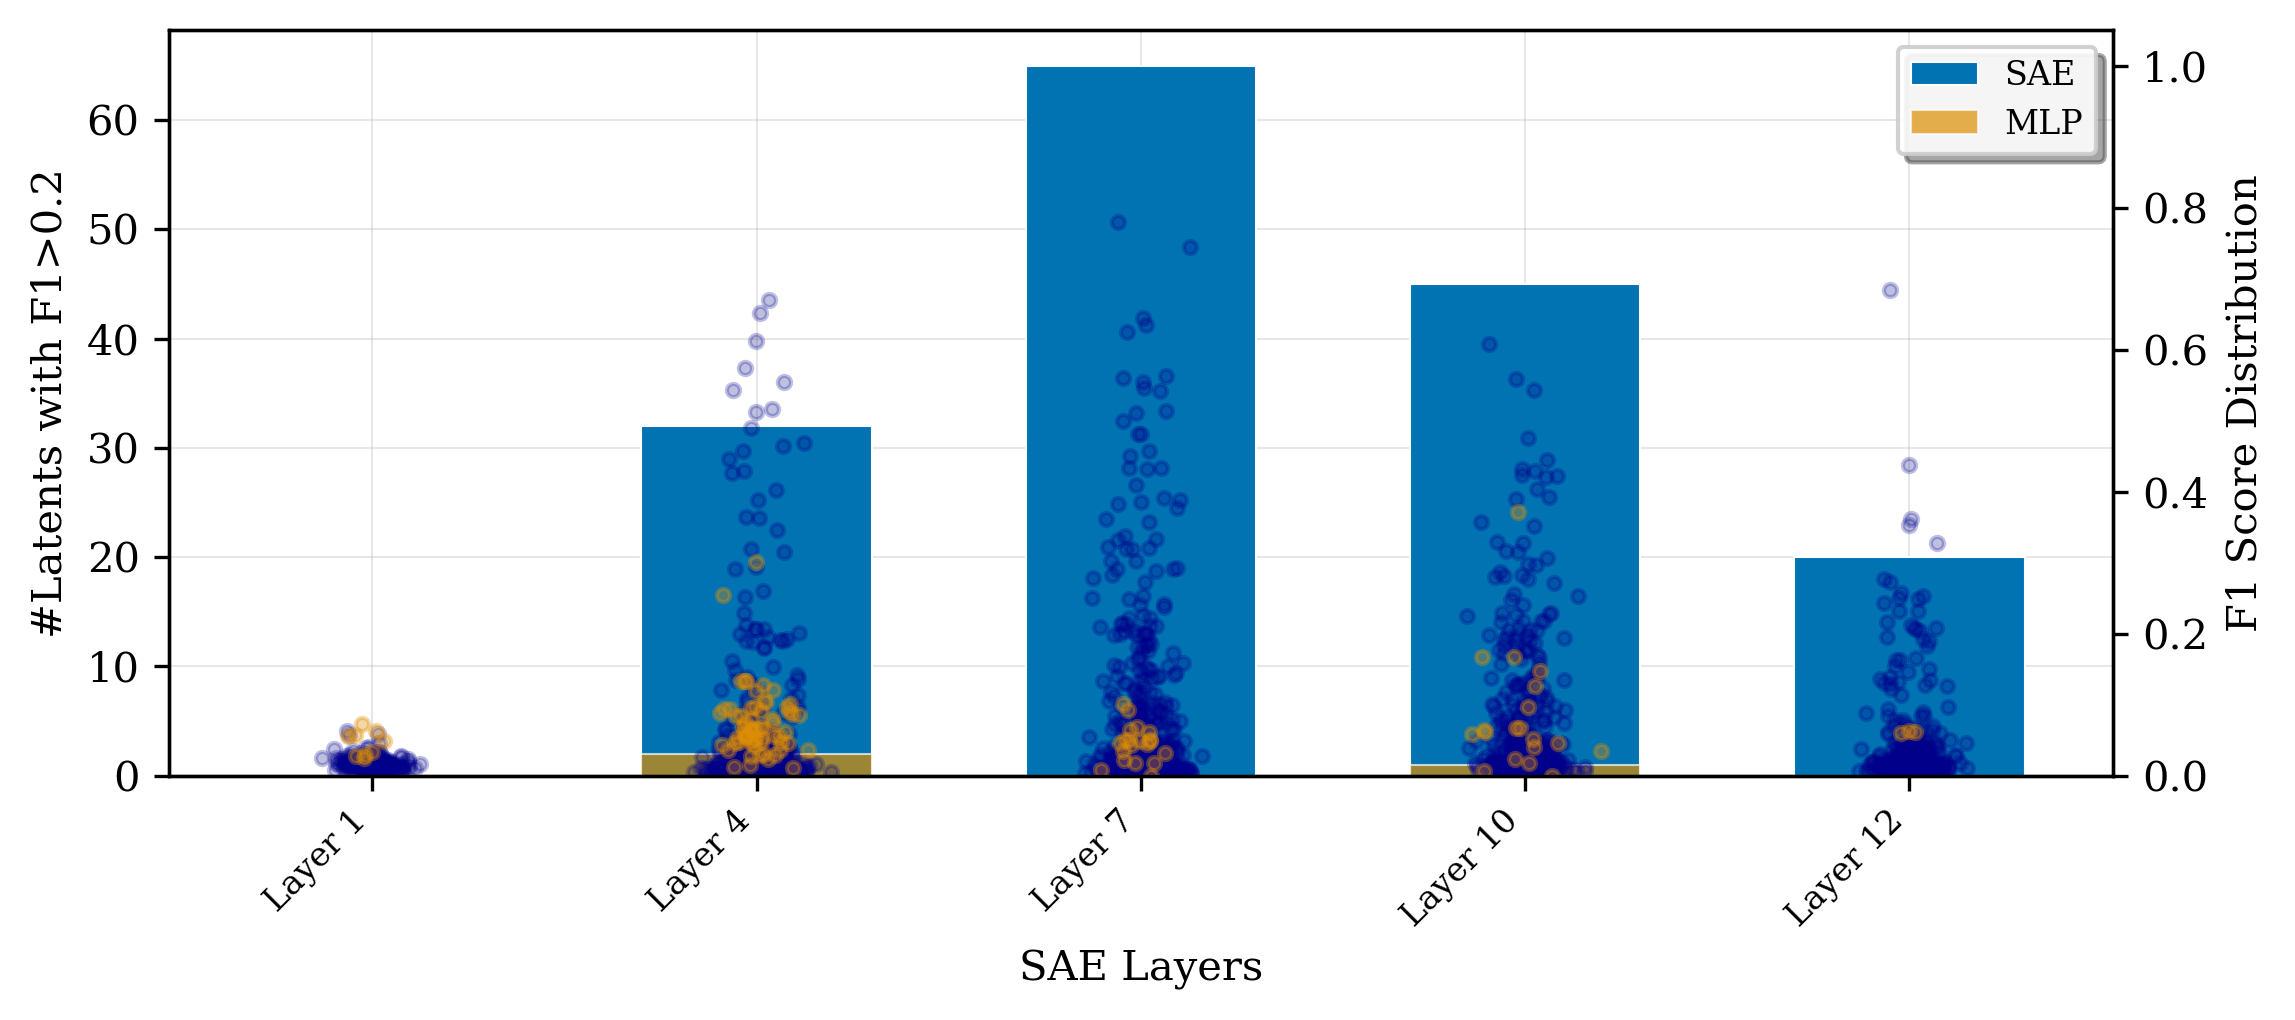

In [24]:
# --- Build summary DataFrame ---
summary_df = pd.DataFrame(layer_threshold_counts).T

# Sort layers numerically
def layer_sort_key(layer):
    match = re.search(r"L(\d+)", layer)
    return int(match.group(1)) if match else 0

summary_df = summary_df.sort_index(key=lambda idx: [layer_sort_key(l) for l in idx])

# Remove unwanted layers (L1, L2)
summary_df = summary_df[~summary_df.index.isin(["L1", "L2"])]

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(7.75, 3.5), dpi=300)
ax2 = ax1.twinx()

x = np.arange(len(summary_df))

# --- Bars ---
ax1.bar(
    x,
    summary_df["sae_above"],
    width=0.6,
    color=colors[0],
    edgecolor="white",
    linewidth=0.5,
    label="SAE",
)

ax1.bar(
    x,
    summary_df["mlp_above"],
    width=0.6,
    color=colors[1],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.7,
    label="MLP",
)

# --- Scatter: SAE F1 values (black) ---
for i, (layer, row) in enumerate(summary_df.iterrows()):
    sae_y = row["sae_f1_values"]
    sae_jitter = np.random.normal(0, 0.05, size=len(sae_y))
    ax2.scatter(
        np.full_like(sae_y, x[i]) + sae_jitter,
        sae_y,
        color="darkblue",
        alpha=0.25,
        s=10,
        label="_nolegend_",
    )

# --- Scatter: MLP F1 values (yellow/orange) ---
for i, (layer, row) in enumerate(summary_df.iterrows()):
    mlp_y = row["mlp_f1_values"]
    if len(mlp_y) == 0:
        continue
    mlp_jitter = np.random.normal(0, 0.05, size=len(mlp_y))
    ax2.scatter(
        np.full_like(mlp_y, x[i]) + mlp_jitter,
        mlp_y,
        color=colors[1],
        alpha=0.35,
        s=10,
        label="_nolegend_",
    )

# --- Axes & labels ---
layer_labels = [f"Layer {layer_sort_key(l)+1}" for l in summary_df.index]
ax1.set_xticks(x)
ax1.set_xticklabels(layer_labels, rotation=45, ha="right", fontsize=8)

ax1.set_xlabel("SAE Layers", fontsize=10)
ax1.set_ylabel(f"#Latents with F1>{T}", fontsize=10)
ax2.set_ylabel("F1 Score Distribution", fontsize=10, color="black")
ax2.set_ylim(0, 1.05)

# --- Grid & aesthetics ---
ax1.grid(True, alpha=0.3, linewidth=0.5)
ax1.set_axisbelow(True)

# --- Legend ---
legend = ax1.legend(
    fontsize=8,
    frameon=True,
    fancybox=True,
    shadow=True,
    loc="upper right",
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)


plt.tight_layout()
plt.show()

In [25]:
df.sort_values(by=['best_f1_avg'], ascending=False)

,latent_id,annotation,best_f1_val2,best_precision_val2,best_recall_val2,threshold,top_10_tokens,best_f1_val1,best_precision_val1,best_recall_val1,threshold_temp,top_10_tokens_temp,best_f1_val0,best_precision_val0,best_recall_val0,threshold_temp,top_10_tokens_temp,best_f1_avg,recall_avg,precision_avg
4,342,['ori'],0.069862,0.053167,0.101839,1,"['ATACCT', 'ATACCT', 'ATACCT', 'ATACCT', 'ATAC...",0.073960,0.059294,0.098265,1,"['ATACCT', 'ATACCT', 'ATACCT', 'ATACCT', 'ATAC...",0.075122,0.060089,0.100189,1,"['ATACCT', 'ATACCT', 'ATACCT', 'ATACCT', 'ATAC...",0.072981,0.100098,0.057517
2,65,['AmpR'],0.065070,0.034649,0.533173,0,"['TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTG...",0.061427,0.032574,0.537685,0,"['TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTG...",0.062974,0.033482,0.528400,0,"['TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTGCG', 'TTTG...",0.063157,0.533086,0.033569
6,400,['AmpR'],0.058848,0.031226,0.509938,0,"['AACTTT', 'AACTTT', 'AACTTT', 'AACTTT', 'AACT...",0.056802,0.030048,0.518211,0,"['AACTTT', 'AACTTT', 'AACTTT', 'AACTTT', 'AACT...",0.057838,0.030659,0.509536,0,"['AACTTT', 'AACTTT', 'AACTTT', 'AACTTT', 'AACT...",0.057829,0.512562,0.030644
0,24,['CMV enhancer'],0.055146,0.028987,0.565070,0,"['GTTTAC', 'TTGACG', 'TTGACG', 'GTTTAC', 'TTGA...",0.059943,0.031626,0.572933,0,"['TTGACG', 'TTGACG', 'TTGACG', 'TTGACG', 'GTTT...",0.054804,0.028786,0.570172,0,"['TTGACG', 'TTGACG', 'TTGACG', 'GTTTAC', 'TTGA...",0.056631,0.569392,0.029800
3,255,['CMV enhancer'],0.046463,0.024118,0.631921,0,"['TTGACG', 'TTGACG', 'TTGACG', 'TTGACG', 'TTGA...",0.051949,0.027102,0.624397,0,"['TTGACG', 'TTGACG', 'TTGACG', 'TTGACG', 'TTGA...",0.046805,0.024310,0.626878,0,"['TTGACG', 'TTGACG', 'TTGACG', 'TTGACG', 'TTGA...",0.048406,0.627732,0.025177
7,426,"['T7 promoter', 'CMV intron']",0.030688,0.043091,0.023829,2,"['TTATCG', 'TTATCG', 'TTATCG', 'TTATCG', 'TTAT...",0.033931,0.051020,0.025418,2,"['TTATCG', 'TTATCG', 'TTATCG', 'TTATCG', 'TTAT...",0.035985,0.056464,0.026407,2,"['TTATCG', 'TTATCG', 'TTATCG', 'TTATCG', 'TTAT...",0.033535,0.025218,0.050192
5,373,['CMV promoter'],0.029579,0.016321,0.157678,1,"['GATGCG', 'GATGCG', 'GATGCG', 'GATGCG', 'GATG...",0.029531,0.016367,0.150888,1,"['CCGCGC', 'GATGCG', 'GATGCG', 'GATGCG', 'GATG...",0.028039,0.015373,0.159226,1,"['GATGCG', 'GATGCG', 'GATGCG', 'GATGCG', 'GATG...",0.029050,0.155931,0.016020
8,467,['SV40 promoter'],0.029781,0.016619,0.143193,1,"['ACCATA', 'ACCATA', 'ACCATA', 'ACCATA', 'ACCA...",0.029115,0.016219,0.142089,1,"['ACCATA', 'ACCATA', 'ACCATA', 'ACCATA', 'ACCA...",0.024022,0.013129,0.141011,1,"['ACCATA', 'ACCATA', 'ACCATA', 'ACCATA', 'ACCA...",0.027640,0.142098,0.015323
1,49,"['EF-1α intron A', 'EF-1α promoter']",0.020291,0.010347,0.520343,0,"['TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCG...",0.031492,0.016234,0.523194,0,"['TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCG...",0.024044,0.012305,0.522949,0,"['TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCGTC', 'TGCG...",0.025276,0.522162,0.012962


# Examples of interpretable SAE-latents

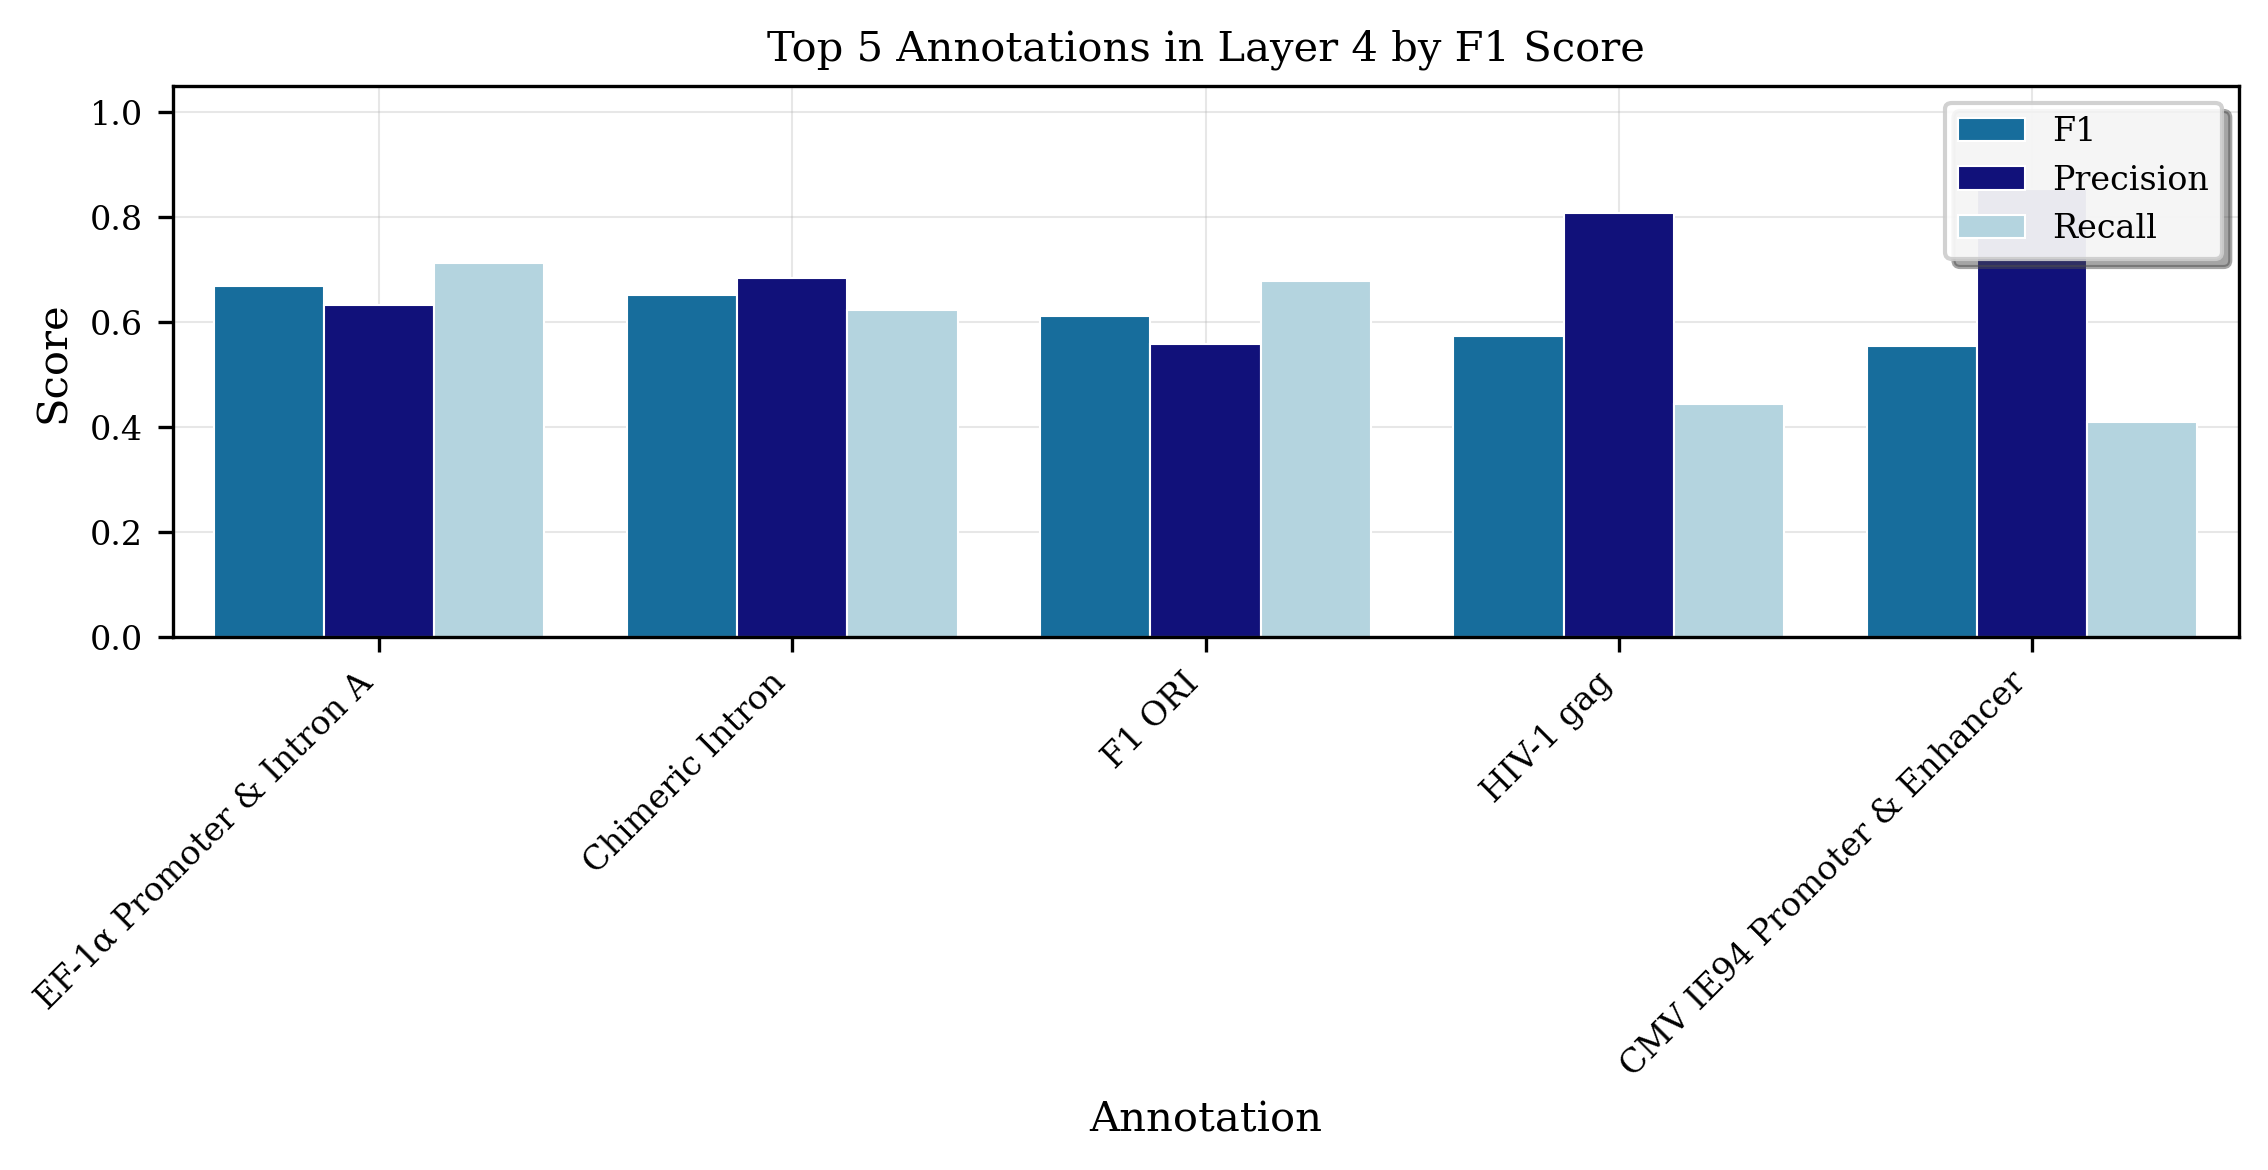

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Visualization setup ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "normal"
colors = sns.color_palette('colorblind')  # we'll still use its blue for F1

# --- Parameters ---
LAYER = "L3"
TOP_K = 5

# --- Extract data ---
df = SAE_50_PATHS.get(LAYER)
if df is None or df.empty:
    raise ValueError(f"No data found for layer {LAYER}")

# --- Identify metric columns ---
f1_cols = [c for c in df.columns if "f1" in c.lower()]
prec_cols = [c for c in df.columns if "precision" in c.lower()]
recall_cols = [c for c in df.columns if "recall" in c.lower()]

# --- Compute averages if not present ---
if "best_f1_avg" not in df.columns and f1_cols:
    df["best_f1_avg"] = df[f1_cols].mean(axis=1)
if "precision_avg" not in df.columns and prec_cols:
    df["precision_avg"] = df[prec_cols].mean(axis=1)
if "recall_avg" not in df.columns and recall_cols:
    df["recall_avg"] = df[recall_cols].mean(axis=1)

annotation_mapping = {
    "['EF-1α promoter', 'EF-1α intron A']": "EF-1α Promoter & Intron A",
    "['chimeric intron']": "Chimeric Intron",
    "['f1 ori']": "F1 ORI",
    "['HIV-1 gag']": "HIV-1 gag",
    "['CMV IE94 promoter', 'CMV enhancer']": "CMV IE94 Promoter & Enhancer",
}
df["annotation"] = df["annotation"].replace(annotation_mapping)


# --- Sort by best F1 and take top K ---
top_df = df.sort_values("best_f1_avg", ascending=False).head(TOP_K)

# --- Prepare dataframe for plotting ---
plot_df = top_df[["annotation", "best_f1_avg", "precision_avg", "recall_avg"]].melt(
    id_vars="annotation", var_name="Metric", value_name="Score"
)

# --- Map clean metric names and define color palette ---
plot_df["Metric"] = plot_df["Metric"].replace({
    "best_f1_avg": "F1",
    "precision_avg": "Precision",
    "recall_avg": "Recall"
})

metric_colors = {
    "F1": colors[0],             # colorblind-safe blue
    "Precision": "darkblue",
    "Recall": "lightblue"
}

# Ensure annotation order matches descending F1
annotation_order = (
    top_df.sort_values("best_f1_avg", ascending=False)["annotation"].tolist()
)

# --- Plot ---
plt.figure(figsize=(7.75, 4), dpi=300)

sns.barplot(
    data=plot_df,
    x="annotation", y="Score", hue="Metric",
    order=annotation_order,
    palette=metric_colors,
    edgecolor="white", linewidth=0.5
)

# --- Aesthetics ---
plt.title(f"Top {TOP_K} Annotations in Layer 4 by F1 Score", fontsize=10)
plt.xlabel("Annotation", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, linewidth=0.5)
plt.gca().set_axisbelow(True)

# --- Legend ---
legend = plt.legend(
    fontsize=8,
    frameon=True,
    fancybox=True,
    shadow=True,
    loc="upper right"
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


# Load sae-latent evals from Nucleotide Transformer (500M)

In [30]:
BASE_PATH_500m = 'data/sae_latent_eval/nt500_base_saes'

SAE_500_PATHS = load_all_layers(BASE_PATH_500m)

for layer, df in SAE_500_PATHS.items():
    # Identify metric columns
    f1_cols = [c for c in df.columns if 'f1' in c.lower()]
    recall_cols = [c for c in df.columns if 'recall' in c.lower()]
    precision_cols = [c for c in df.columns if 'precision' in c.lower()]

    # Compute averages
    df = add_average_metrics(df, f1_cols, recall_cols, precision_cols)

    # Keep only existing columns
    keep_cols = ['latent_id', 'annotation']
    for col in ['best_f1_avg', 'recall_avg', 'precision_avg']:
        if col in df.columns:
            keep_cols.append(col)

    SAE_500_PATHS[layer] = df[keep_cols]


Processing 2025-10-14_10-04-49_nt500_L9_batchtopk_standard-20260204T180828Z-3-001 (→ L9)


In [31]:
SAE_500_PATHS["L9"].sort_values(by=['best_f1_avg'], ascending=False)

,latent_id,annotation,best_f1_avg,recall_avg,precision_avg
818,5561,['small t antigen'],0.873044,0.821707,0.932271
472,3322,['rrnB T2 terminator'],0.764904,0.645379,0.940377
698,4837,['TEF promoter'],0.742194,0.644300,0.875937
578,4067,['araC'],0.739604,0.875866,0.646031
447,3104,['gag (truncated)'],0.737920,0.590298,0.984154
...,...,...,...,...,...
204,1477,['ori'],0.011656,0.006372,0.068378
261,1839,"['EF-1α intron A', 'EF-1α promoter']",0.010844,0.006735,0.028751
706,4895,['UL126'],0.010661,0.006974,0.022638
1089,7449,['ori'],0.009950,0.005772,0.036071


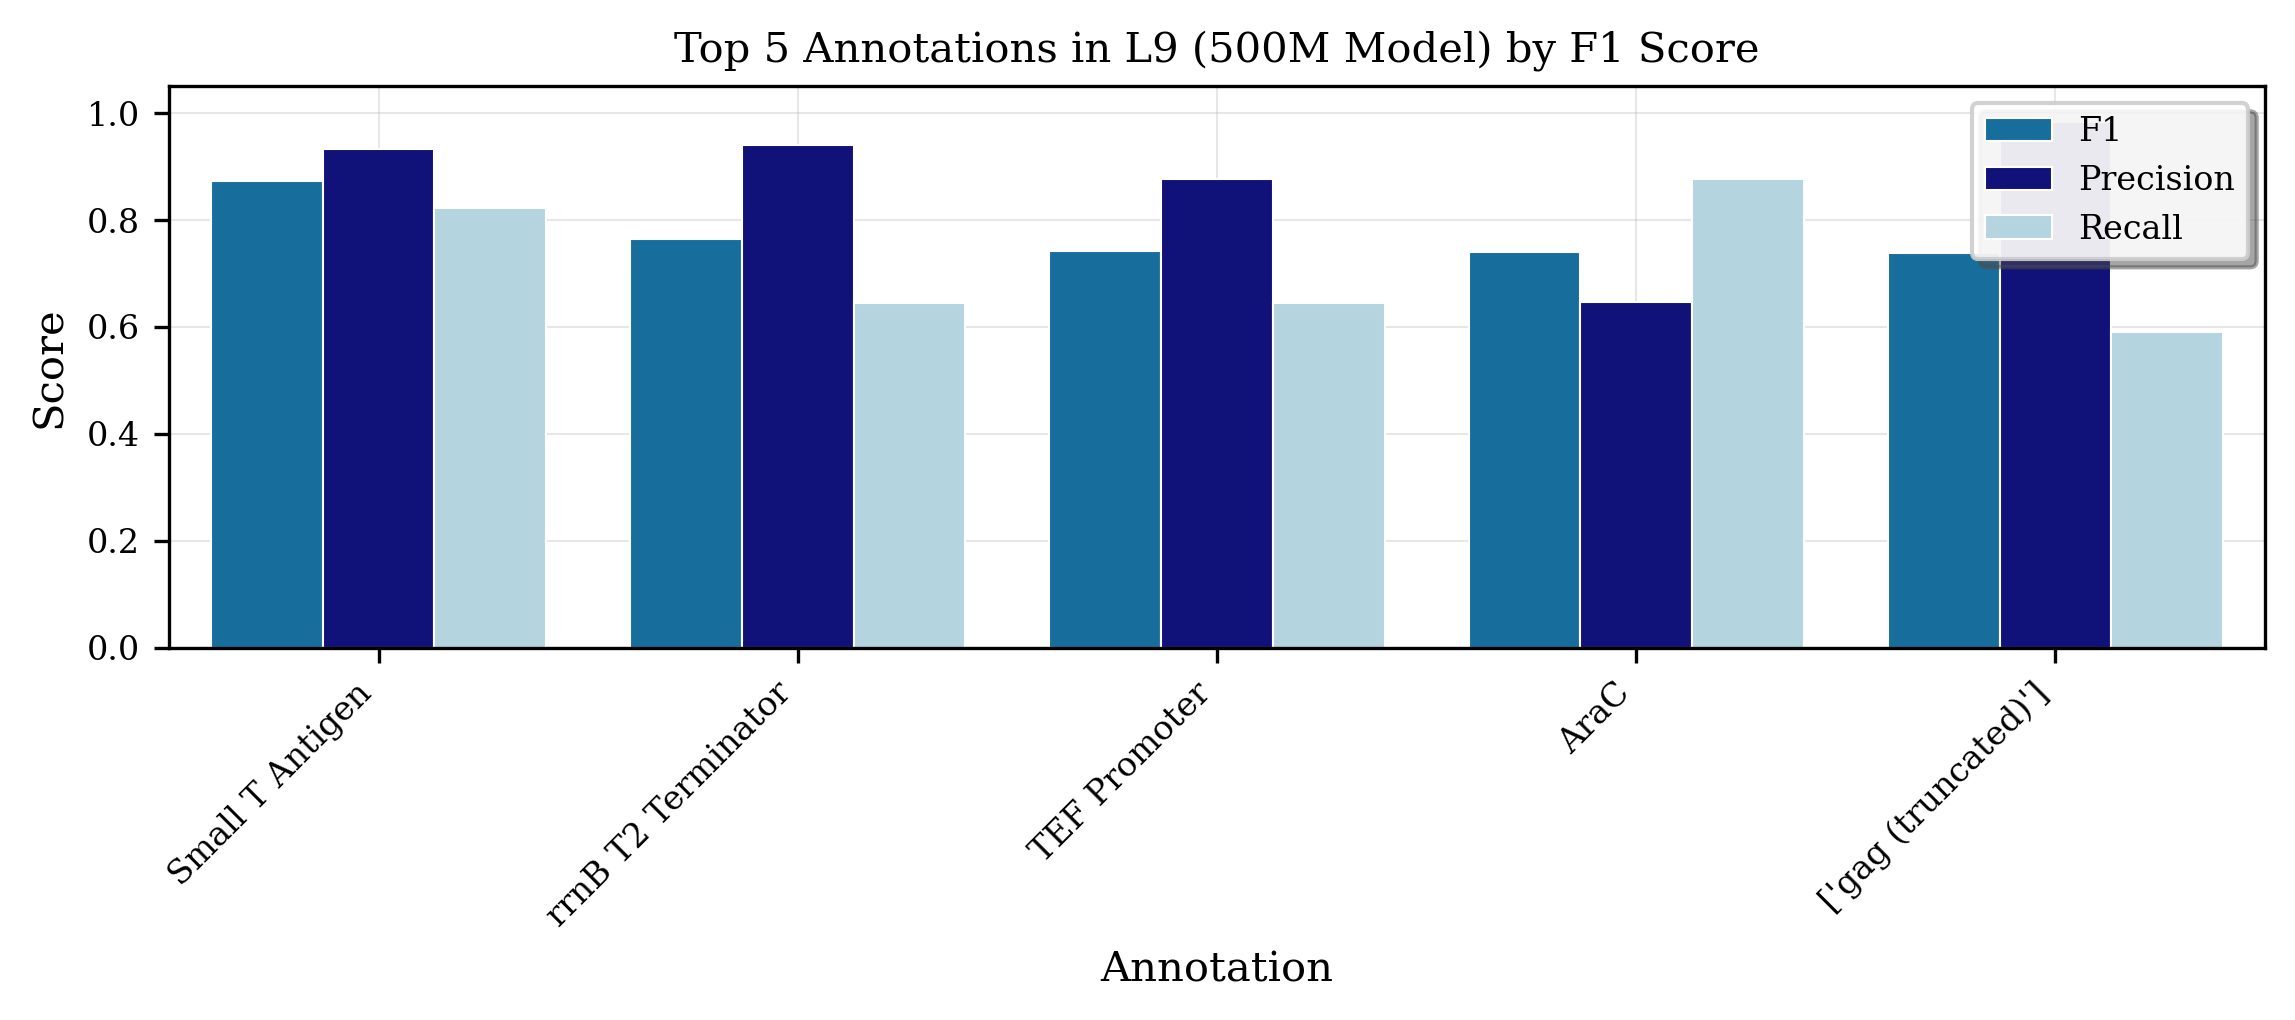

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Visualization setup ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "normal"
colors = sns.color_palette('colorblind')  # use same consistent palette

# --- Parameters ---
LAYER = "L9"
TOP_K = 5

# --- Extract data from the large (500M) model ---
df = SAE_500_PATHS.get(LAYER)
if df is None or df.empty:
    raise ValueError(f"No data found for layer {LAYER} in the 500M model")

# --- Identify metric columns ---
f1_cols = [c for c in df.columns if "f1" in c.lower()]
prec_cols = [c for c in df.columns if "precision" in c.lower()]
recall_cols = [c for c in df.columns if "recall" in c.lower()]

# --- Compute averages if not already present ---
if "best_f1_avg" not in df.columns and f1_cols:
    df["best_f1_avg"] = df[f1_cols].mean(axis=1)
if "precision_avg" not in df.columns and prec_cols:
    df["precision_avg"] = df[prec_cols].mean(axis=1)
if "recall_avg" not in df.columns and recall_cols:
    df["recall_avg"] = df[recall_cols].mean(axis=1)

annotation_mapping = {
    "['araC']": "AraC",
    "['TEF promoter']": "TEF Promoter",
    "['rrnB T2 terminator']": "rrnB T2 Terminator",
    "['small t antigen']": "Small T Antigen",
    "gag (truncated)": "Gag (Truncated)"
}


# --- Clean up annotations before using them ---
df["annotation"] = df["annotation"].replace(annotation_mapping)


# --- Sort by best F1 and take top K ---
top_df = df.sort_values("best_f1_avg", ascending=False).head(TOP_K)

# --- Prepare dataframe for plotting ---
plot_df = top_df[["annotation", "best_f1_avg", "precision_avg", "recall_avg"]].melt(
    id_vars="annotation", var_name="Metric", value_name="Score"
)

# --- Map clean metric names and define color palette ---
plot_df["Metric"] = plot_df["Metric"].replace({
    "best_f1_avg": "F1",
    "precision_avg": "Precision",
    "recall_avg": "Recall"
})

metric_colors = {
    "F1": colors[0],             # colorblind-safe blue
    "Precision": "darkblue",
    "Recall": "lightblue"
}

# Ensure annotation order matches descending F1
annotation_order = (
    top_df.sort_values("best_f1_avg", ascending=False)["annotation"].tolist()
)

# --- Plot ---
plt.figure(figsize=(7.75, 3.5), dpi=300)

sns.barplot(
    data=plot_df,
    x="annotation", y="Score", hue="Metric",
    order=annotation_order,
    palette=metric_colors,
    edgecolor="white", linewidth=0.5
)

# --- Aesthetics ---
plt.title(f"Top {TOP_K} Annotations in {LAYER} (500M Model) by F1 Score", fontsize=10)
plt.xlabel("Annotation", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, linewidth=0.5)
plt.gca().set_axisbelow(True)

# --- Legend ---
legend = plt.legend(
    fontsize=8,
    frameon=True,
    fancybox=True,
    shadow=True,
    loc="upper right"
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


# How many total unique concepts?

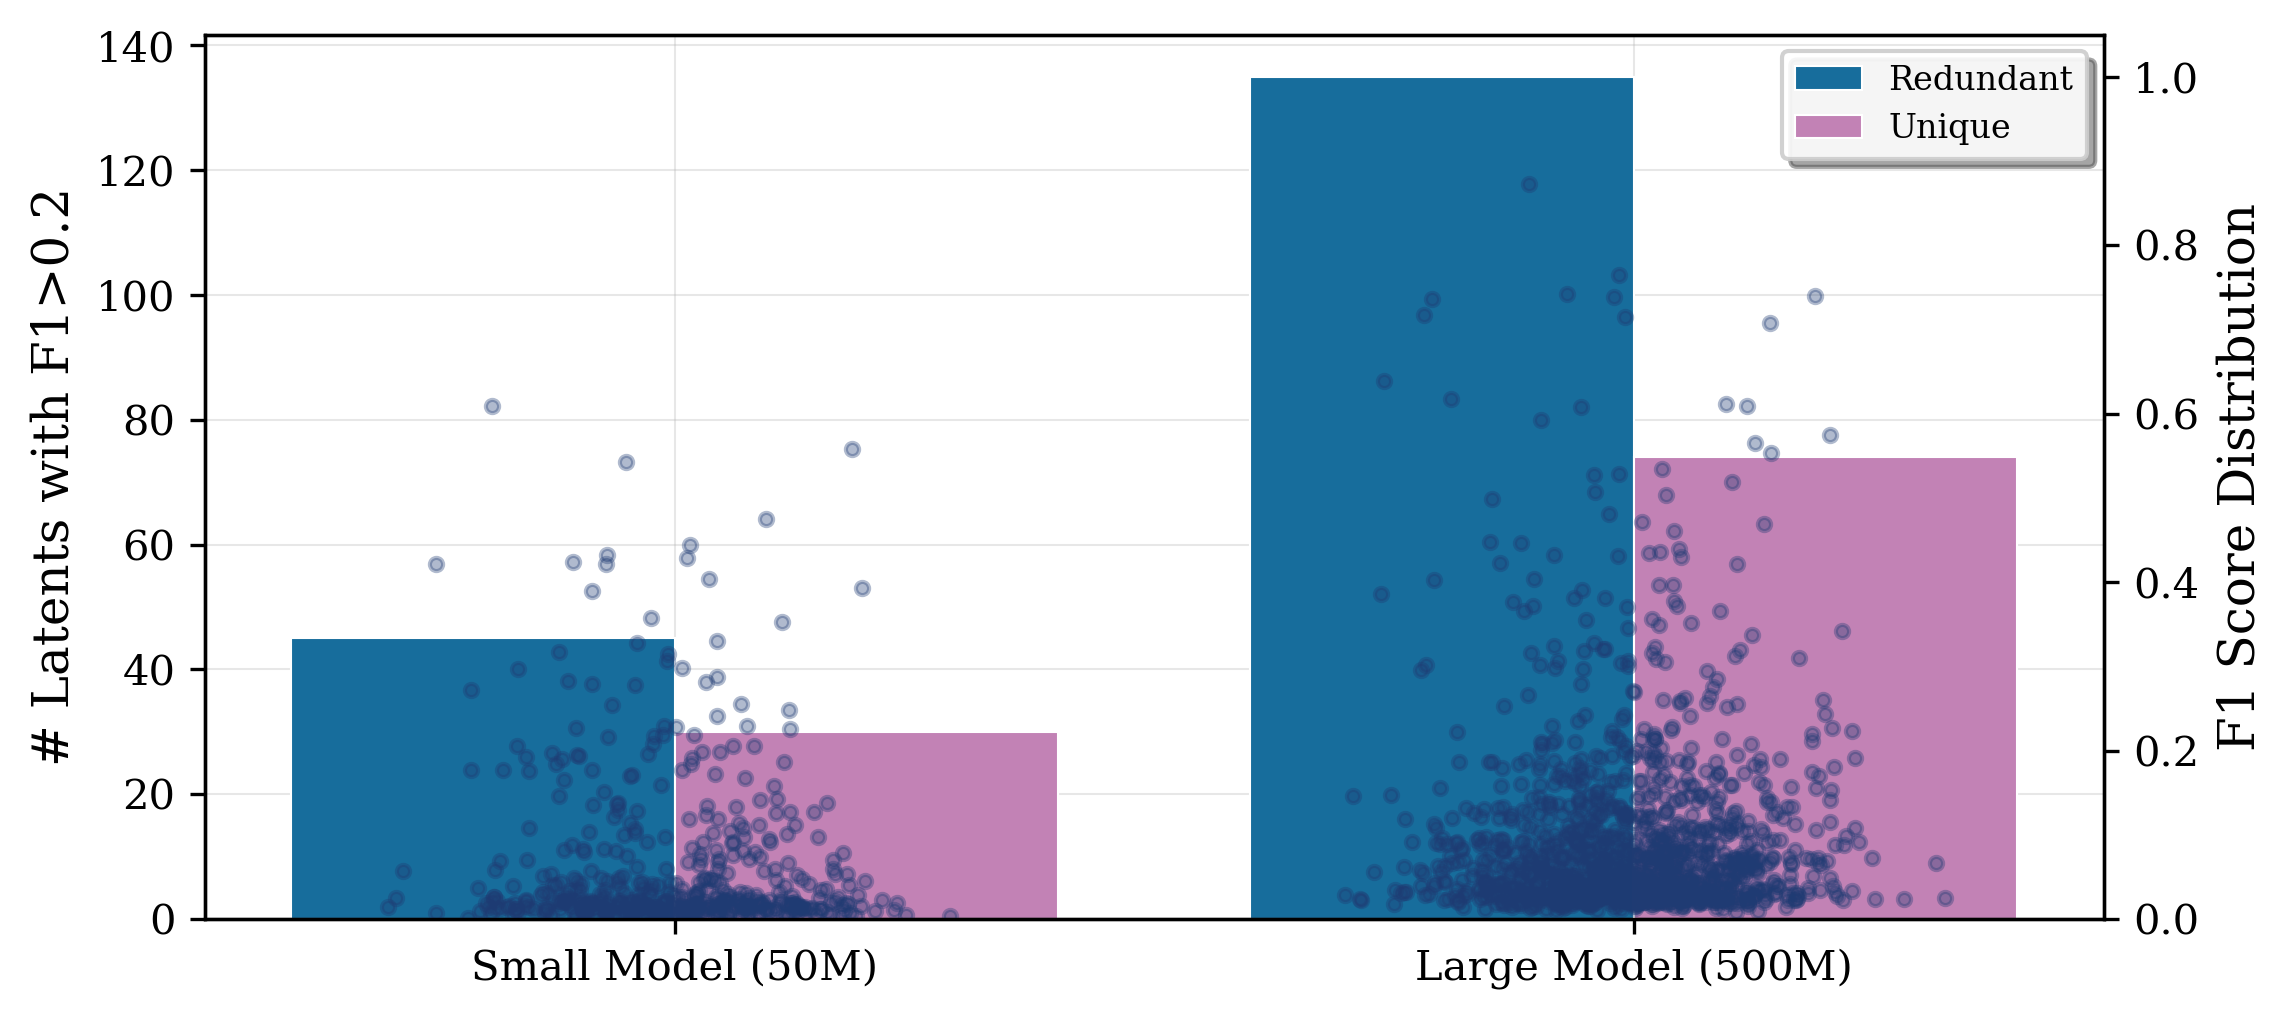

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Visualization setup ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "normal"
colors = sns.color_palette('colorblind')

# --- Parameters ---
LAYER = "L9"
T = 0.2
MODEL_LABELS = ["Small Model (50M)", "Large Model (500M)"]
F1_COLOR = "#1f3b73"  # dark blue for right y-axis & scatter

# --- Extract data ---
df_small = SAE_50_PATHS.get(LAYER)
df_large = SAE_500_PATHS.get(LAYER)

if df_small is None or df_small.empty or df_large is None or df_large.empty:
    raise ValueError(f"Missing or empty data for layer {LAYER} in one or both models.")

# --- Compute metrics ---
small_latents = (df_small['best_f1_avg'] > T).sum()
large_latents = (df_large['best_f1_avg'] > T).sum()
small_unique = df_small.loc[df_small['best_f1_avg'] > T, 'annotation'].nunique()
large_unique = df_large.loc[df_large['best_f1_avg'] > T, 'annotation'].nunique()

# --- Summary DataFrame (long format for grouped bars) ---
summary_df = pd.DataFrame({
    "Model": np.repeat(MODEL_LABELS, 2),
    "Metric": ["Redundant", "Unique"] * 2,
    "Count": [small_latents, small_unique, large_latents, large_unique]
})

# --- Combine F1 values for scatter ---
f1_df = pd.concat([
    pd.DataFrame({"Model": MODEL_LABELS[0], "F1": df_small["best_f1_avg"]}),
    pd.DataFrame({"Model": MODEL_LABELS[1], "F1": df_large["best_f1_avg"]})
])

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(7.75, 3.5), dpi=300)
ax2 = ax1.twinx()

# --- Bar plot (grouped) ---
sns.barplot(
    data=summary_df, x="Model", y="Count", hue="Metric",
    palette=[colors[0], colors[4]],  # blue for latents, orange for annotations
    edgecolor="white", linewidth=0.5, ax=ax1
)

# --- Scatter F1 values (right y-axis, dark blue) ---
for i, (model_label, f1_values) in enumerate(zip(MODEL_LABELS, [df_small['best_f1_avg'], df_large['best_f1_avg']])):
    jitter = np.random.normal(0, 0.1, size=len(f1_values))
    ax2.scatter(
        np.full_like(f1_values, i) + jitter,
        f1_values,
        s=10,
        color=F1_COLOR,
        alpha=0.35,
        label="_nolegend_"
    )

# --- Axes ---
ax1.set_xlabel("")
ax1.set_ylabel(f"# Latents with F1>{T}", fontsize=12)
ax2.set_ylabel("F1 Score Distribution", fontsize=12)
ax2.set_ylim(0, 1.05)

ax1.grid(True, alpha=0.3, linewidth=0.5)
ax1.set_axisbelow(True)

# --- Legend ---
legend = ax1.legend(
    fontsize=8, frameon=True, fancybox=True, shadow=True, loc="upper right"
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)


plt.tight_layout()
plt.show()


In [36]:
# filter all dfs for rows with best_f1 > 0.2 then get the set of all annotations across dfs

# filter all SAE_50_PATH dfs for rows with best_f1 > 0.2
T = 0.2
SAE_50_PATHS_filtered = {layer: df[df['best_f1_avg'] > T].copy() for layer, df in SAE_50_PATHS.items()}
SAE_50_PATHS_filtered

SAE_500_PATHS_filtered = {layer: df[df['best_f1_avg'] > T].copy() for layer, df in SAE_500_PATHS.items()}
SAE_500_PATHS_filtered


# now get the set of all annotations across dfs
all_annotations = set()
for df in SAE_50_PATHS_filtered.values():
    all_annotations.update(df['annotation'].unique())

for df in SAE_500_PATHS_filtered.values():
    all_annotations.update(df['annotation'].unique())


# Lets get one large df that shows each of the unique annotations together with the layer and f1-score.
# Lets add a column with a layer identiier to each of the dfs_filtered
for layer, df in SAE_50_PATHS_filtered.items():
    df['layer'] = layer
    df['model'] = '50M'
for layer, df in SAE_500_PATHS_filtered.items():
    df['layer'] = layer
    df['model'] = '500M'

# Lets then concatenate the all filtered dfs
sae_50and500M_dfs = pd.concat(SAE_50_PATHS_filtered.values(), ignore_index=True)



# Now lets order descendingly by best_f1_avg and keep only the first row for each anntoation
sae_50and500M_dfs= sae_50and500M_dfs.sort_values('best_f1_avg', ascending=False)
sae_50and500M_dfs = sae_50and500M_dfs.drop_duplicates(subset='annotation', keep='first')
sae_50and500M_dfs

print(f"Total unique concepts: {len(sae_50and500M_dfs)}")

Total unique concepts: 71
